# Economic Data Analysis with Fred & Pandas

This project, conducted in Jupyter Notebook and intended for my data analysis portfolio, involves pulling economic data from the Federal Reserve Economic Data (FRED) using the `fredapi` library. The analysis is performed using `pandas`, `numpy`, `matplotlib`, and `plotly`.

### Setup
To set up the project, install the required libraries by running the following command:

In [ ]:
!pip install -r requirements.txt

### Configuration and API Key Setup

This section initializes the configuration and API key setup for the project. It includes loading necessary libraries, configuring options, and retrieving the API key from the `config.ini` file using the `configparser` module. The `fredapi` library is then used to set up the Fred object with the obtained API key.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

# Set the style for plots
plt.style.use('fivethirtyeight')

# Set max_columns option for pandas display
with pd.option_context('display.max_columns', 500):
    color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [4]:
# Read API key from config.ini
import configparser
config = configparser.ConfigParser()
config.read('config.ini')

# Check if 'API_KEYS' section and 'fred_key' key exist in config.ini
if 'API_KEYS' in config and 'fred_key' in config['API_KEYS']:
    fred_key = config['API_KEYS']['fred_key']
else:
    print("Error: 'API_KEYS' section or 'fred_key' key not found in config.ini")

In [5]:
# Initialize Fred object with API key (if available)
from fredapi import Fred
fred = Fred(api_key=fred_key) if fred_key else Fred()

### Search for S&P Economic Data

This code queries the FRED database for economic data related to the S&P index, ordered by popularity.

In [23]:
# Search for economic data related to S&P with order by popularity
sp_search = fred.search('S&P', order_by='popularity')

# Display the first few rows of the search results
sp_search.head()


id realtime_start realtime_end  \
series id                                                    
BAMLH0A0HYM2      BAMLH0A0HYM2     2024-01-21   2024-01-21   
CSUSHPINSA          CSUSHPINSA     2024-01-21   2024-01-21   
SP500                    SP500     2024-01-21   2024-01-21   
MEHOINUSA672N    MEHOINUSA672N     2024-01-21   2024-01-21   
BAMLH0A0HYM2EY  BAMLH0A0HYM2EY     2024-01-21   2024-01-21   

                                                            title  \
series id                                                           
BAMLH0A0HYM2    ICE BofA US High Yield Index Option-Adjusted S...   
CSUSHPINSA      S&P CoreLogic Case-Shiller U.S. National Home ...   
SP500                                                     S&P 500   
MEHOINUSA672N   Real Median Household Income in the United States   
BAMLH0A0HYM2EY       ICE BofA US High Yield Index Effective Yield   

               observation_start observation_end     frequency  \
series id                                                        
BAMLH0A0HYM2          1996-12-31      2024-01-18  Daily, Close   
CSUSHPINSA            1987-01-01      2023-10-01       Monthly   
SP500                 2014-01-21      2024-01-19  Daily, Close   
MEHOINUSA672N         1984-01-01      2022-01-01        Annual   
BAMLH0A0HYM2EY        1996-12-31      2024-01-18  Daily, Close   

               frequency_short                           units  \
series id                                                        
BAMLH0A0HYM2                 D                         Percent   
CSUSHPINSA                   M              Index Jan 2000=100   
SP500                        D                           Index   
MEHOINUSA672N                A  2022 CPI-U-RS Adjusted Dollars   
BAMLH0A0HYM2EY               D                         Percent   

                             units_short      seasonal_adjustment  \
series id                                                           
BAMLH0A0HYM2                           %  Not Seasonally Adjusted   
CSUSHPINSA            Index Jan 2000=100  Not Seasonally Adjusted   
SP500                              Index  Not Seasonally Adjusted   
MEHOINUSA672N   2022 CPI-U-RS Adjusted $  Not Seasonally Adjusted   
BAMLH0A0HYM2EY                         %  Not Seasonally Adjusted   

               seasonal_adjustment_short               last_updated  \
series id                                                             
BAMLH0A0HYM2                         NSA  2024-01-19 08:09:03-06:00   
CSUSHPINSA                           NSA  2023-12-26 08:12:02-06:00   
SP500                                NSA  2024-01-19 19:11:02-06:00   
MEHOINUSA672N                        NSA  2023-09-12 13:48:02-05:00   
BAMLH0A0HYM2EY                       NSA  2024-01-19 08:09:07-06:00   

               popularity                                              notes  
series id                                                                     
BAMLH0A0HYM2           92  The ICE BofA Option-Adjusted Spreads (OASs) ar...  
CSUSHPINSA             87  For more information regarding the index, plea...  
SP500                  83  The observations for the S&P 500 represent the...  
MEHOINUSA672N          82  Household data are collected as of March.  As ...  
BAMLH0A0HYM2EY         82  This data represents the effective yield of th...

### Plotting S&P 500 Data

To visualize the S&P 500 data, the code uses the `get_series` method from the `fred` library to fetch the series with the ID 'SP500'. The resulting time series is then plotted using `matplotlib.pyplot` with a specified figure size, title, and line width.

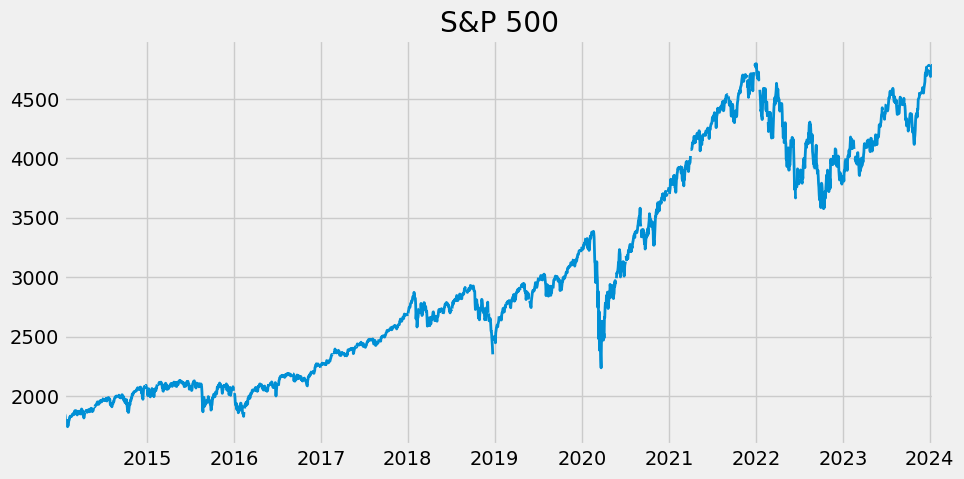

In [24]:
# Fetch S&P 500 data from FRED using the series ID 'SP500'
sp500 = fred.get_series(series_id='SP500')

# Plot the S&P 500 data with specified figure size, title, and line width
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)

# Display the plot
plt.show()

### Fetching and Processing Unemployment Rate Data for States

This section of the code involves searching for unemployment rate data for states, filtering and processing the data, and creating a DataFrame with relevant information.

In [25]:
# Search for unemployment rate data for states with monthly frequency
unemp_df = fred.search('unemployment rate state', filter=('frequency', 'Monthly'))

# Filter criteria: Include only Seasonally Adjusted rates in percent
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

# Select relevant data: Focus on entries containing "Unemployment Rate" in the title
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [26]:
# Initialize an empty list to store individual series
all_results = []

# Iterate through the index of the filtered unemployment rate DataFrame
for myid in unemp_df.index:
    # Get the time series data for each state
    results = fred.get_series(myid)
    
    # Convert the series to a DataFrame with the series ID as the column name
    results = results.to_frame(name=myid)
    
    # Append the DataFrame to the list
    all_results.append(results)
    
    # Pause to avoid making requests too quickly and getting blocked
    time.sleep(0.1)

# Concatenate all individual DataFrames into a single DataFrame
uemp_results = pd.concat(all_results, axis=1)


In [27]:
# Initialize a list to store columns to be dropped
cols_to_drop = []

# Iterate through columns of the unemployment results DataFrame
for i in uemp_results:
    # Check if the column name length is greater than 4
    if len(i) > 4:
        # Add column name to the list of columns to be dropped
        cols_to_drop.append(i)

# Drop specified columns from the unemployment results DataFrame
uemp_results = uemp_results.drop(columns=cols_to_drop, axis=1)

In [28]:
# Create a copy of the unemployment results DataFrame
uemp_states = uemp_results.copy()

# Drop rows with missing values
uemp_states = uemp_states.dropna()

# Create a dictionary mapping column names to state names
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()

# Rename columns in the state-wise unemployment DataFrame using the dictionary
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [29]:
# Use Plotly Express to create a line plot of States Unemployment Rate
px.line(uemp_states)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=California<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'California',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'California',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(1976, 1, 1, 0, 0),
                          datetime.datetime(1976, 2, 1, 0, 0),
                          datetime.datetime(1976, 3, 1, 0, 0), ...,
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 10, 1, 0, 0),
                          datetime.datetime(2023, 11, 1, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([9.2, 9.2, 9.1, ..., 4.7, 4.8, 4.9]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=Texas<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Texas',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Texas',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(1976, 1, 1, 0, 0),
                          datetime.datetime(1976, 2, 1, 0, 0),
                          datetime.datetime(1976, 3, 1, 0, 0), ...,
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 10, 1, 0, 0),
                          datetime.datetime(2023, 11, 1, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([5.8, 5.8, 5.9, ..., 4.1, 4.1, 4.1]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=New York<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'New York',
              'line': {'color': '#00cc96', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'New York',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(1976, 1, 1, 0, 0),
                          datetime.datetime(1976, 2, 1, 0, 0),
                          datetime.datetime(1976, 3, 1, 0, 0), ...,
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 10, 1, 0, 0),
                          datetime.datetime(2023, 11, 1, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([10.3, 10.3, 10.2, ...,  4. ,  4.2,  4.3]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=Florida<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Florida',
              'line': {'color': '#ab63fa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Florida',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(1976, 1, 1, 0, 0),
                          datetime.datetime(1976, 2, 1, 0, 0),
                          datetime.datetime(1976, 3, 1, 0, 0), ...,
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 10, 1, 0, 0),
                          datetime.datetime(2023, 11, 1, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([9.7, 9.7, 9.6, ..., 2.8, 2.8, 2.9]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=Pennsylvania<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Pennsylvania',
              'line': {'color': '#FFA15A', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Pennsylvania',
              'showlegend': True,
              'type': 'scattergl',
          

### Bar Chart: Unemployment Rate by State (May 2023)

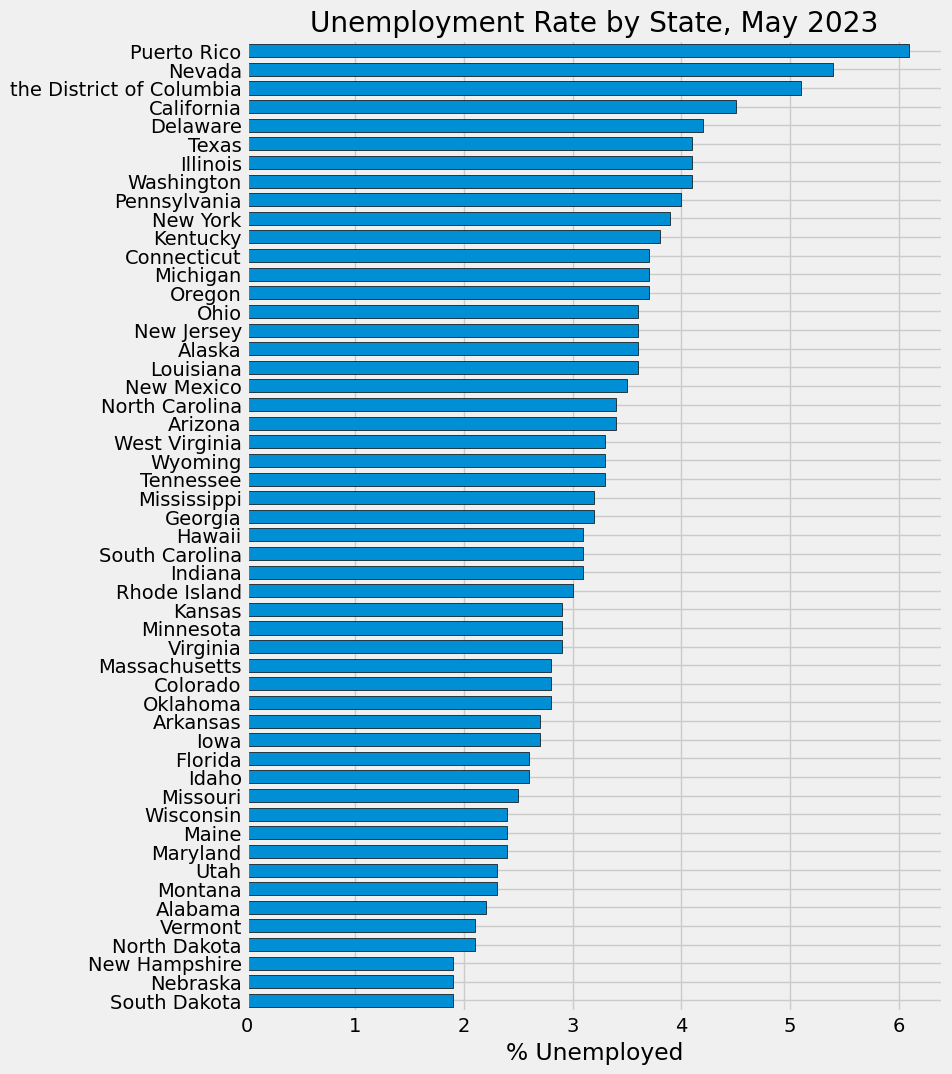

In [30]:
# Create a horizontal bar chart for Unemployment Rate by State in May 2023
ax = uemp_states.loc[uemp_states.index == '2023-05-01'].T \
    .sort_values('2023-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2023')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

## Labor Force Participation Rate by State

### Search for Participation Rate Data

In [33]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

In [37]:
# Initialize an empty list to store results
all_results = []

# Iterate over the index of the DataFrame containing participation rate search results
for myid in part_df.index:
    # Retrieve time series data for the specified series ID
    results = fred.get_series(myid)
    
    # Convert the data to a DataFrame with a specified column name
    results = results.to_frame(name=myid)
    
    # Append the DataFrame to the list
    all_results.append(results)
    
    # Pause to avoid making requests too quickly and getting blocked
    time.sleep(0.1)

# Concatenate all DataFrames in the list along the columns axis
part_states = pd.concat(all_results, axis=1)

# Rename columns using the dictionary created earlier
part_states.columns = [part_id_to_state[c] for c in part_states.columns]


In [35]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

## Plot Unemployment vs Participation for Multiple States Over Time

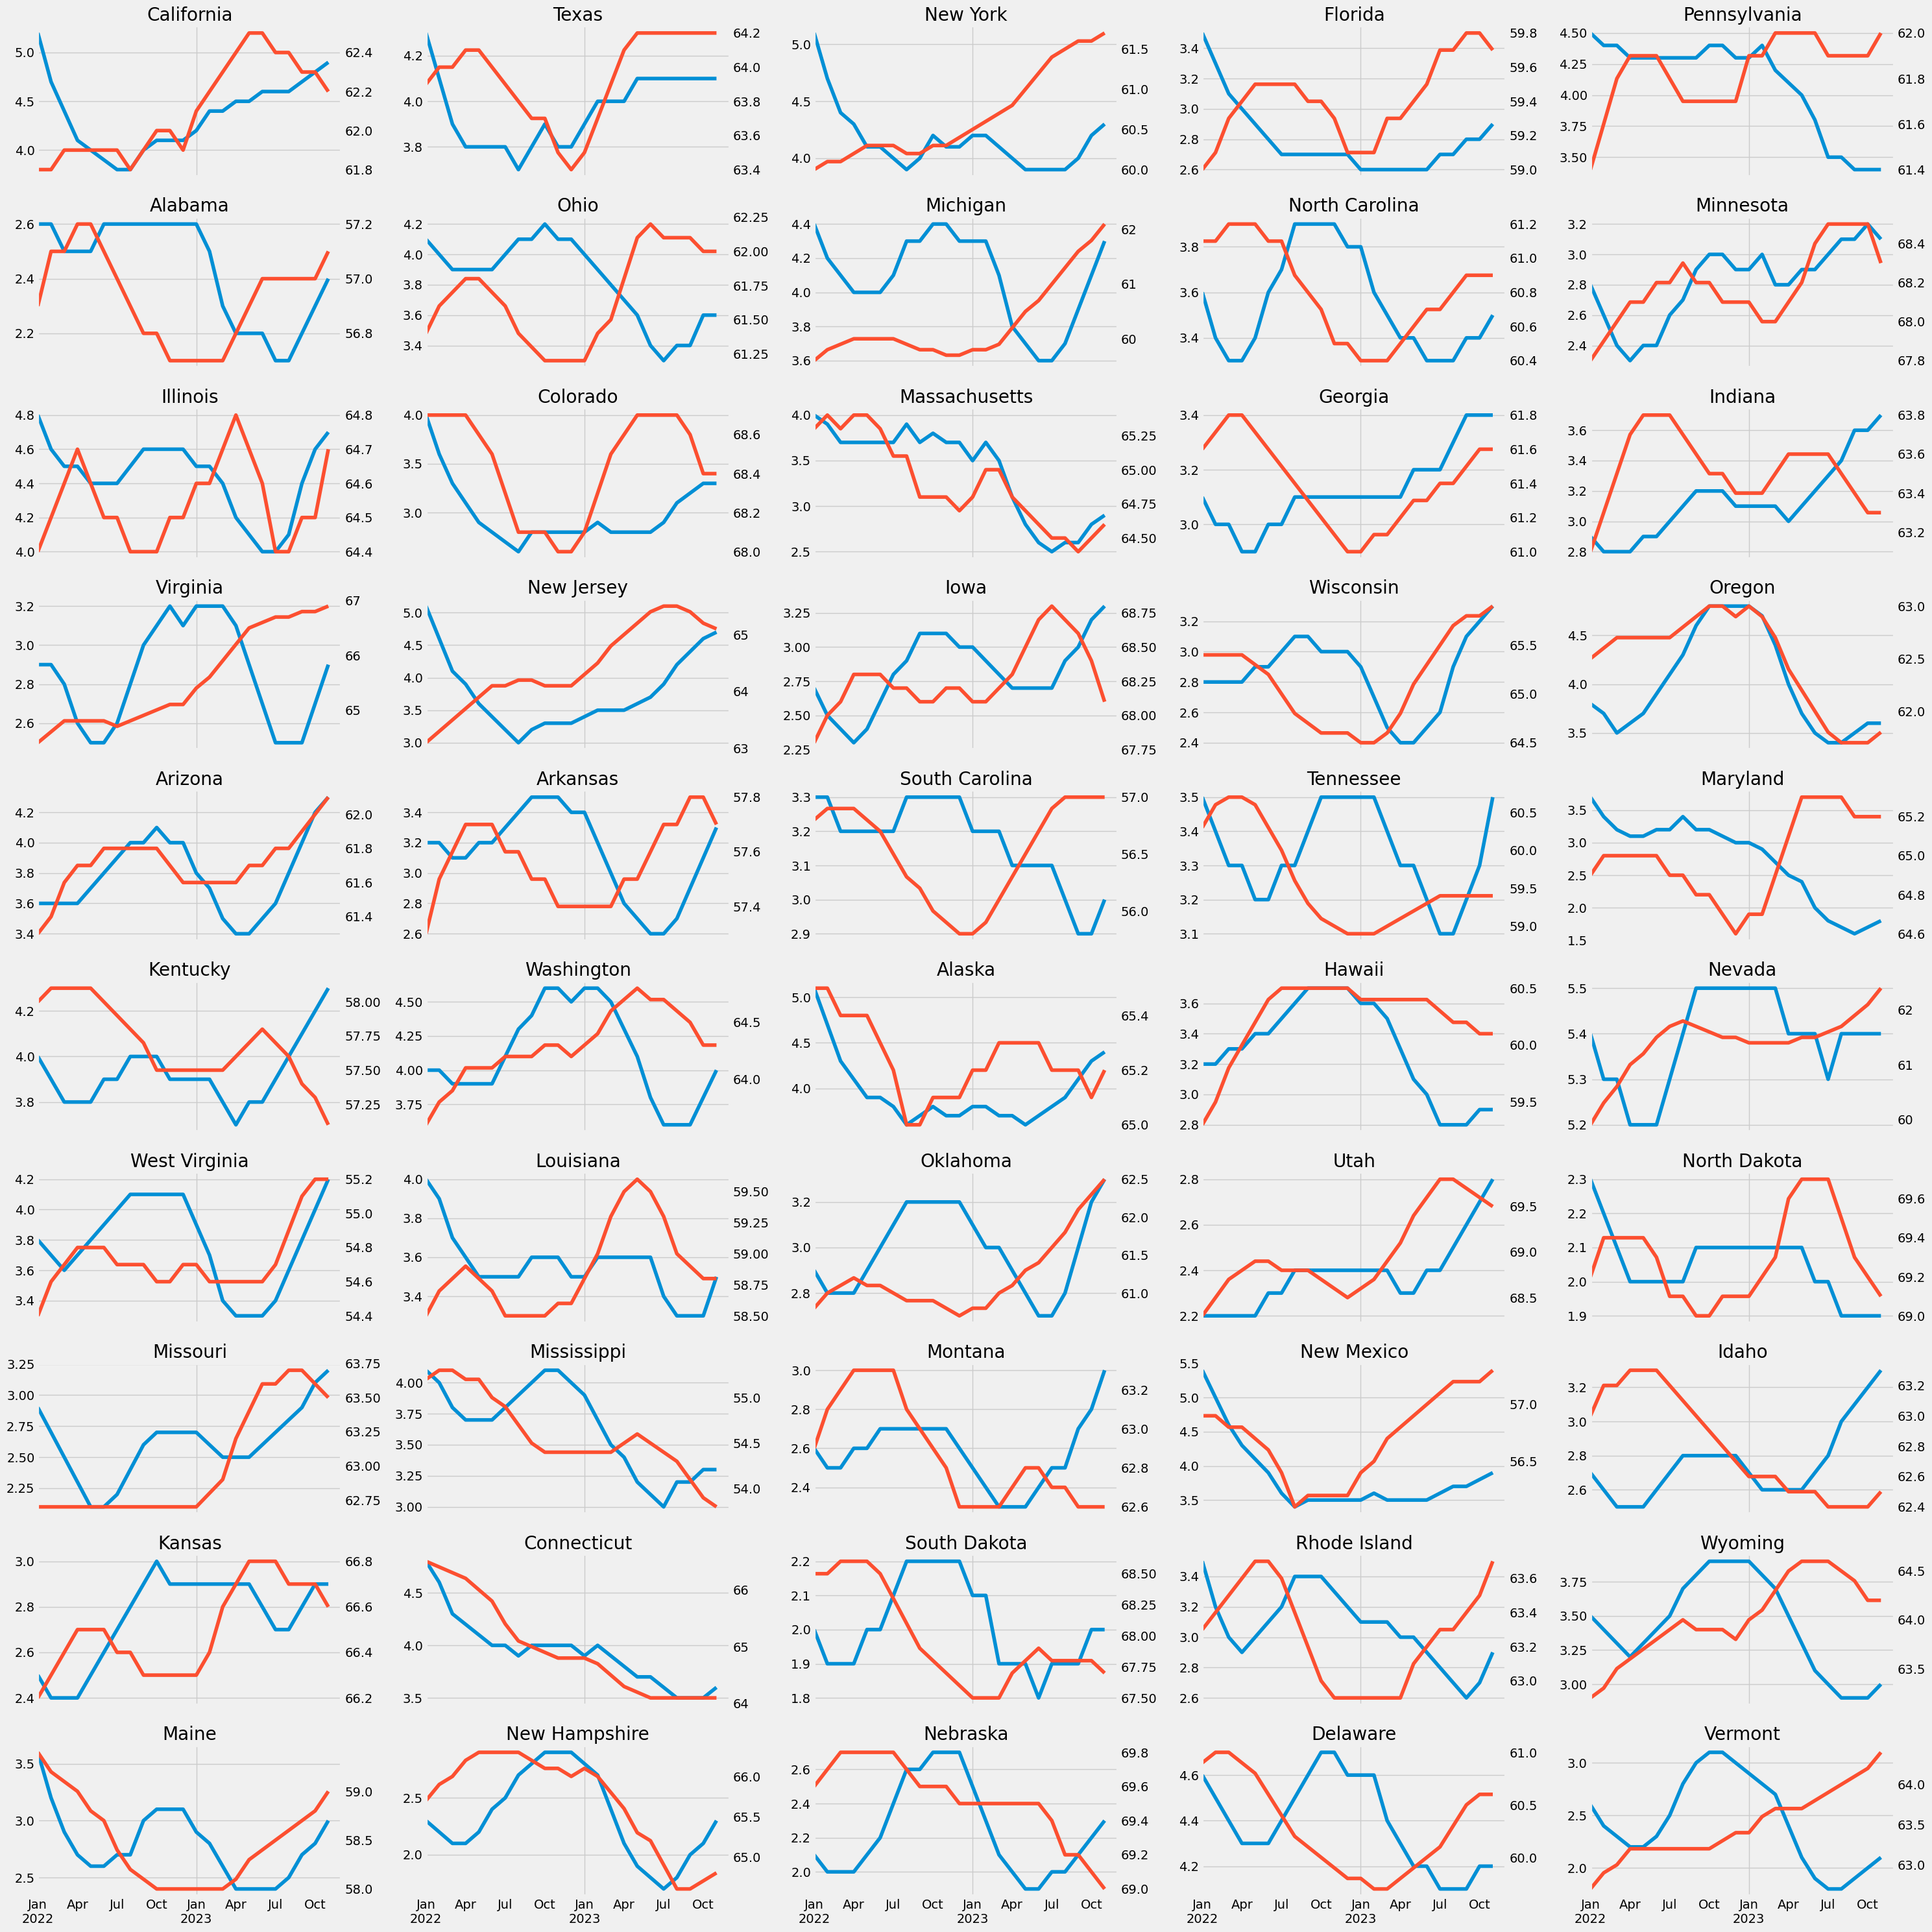

In [38]:
# Create subplots with 10 rows and 5 columns
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

# Initialize index variable
i = 0

# Iterate over each state in the DataFrame columns
for state in uemp_states.columns:
    # Skip specific states
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    
    # Create a twin Axes for the second y-axis
    ax2 = axs[i].twinx()
    
    # Plot Unemployment data for the specified time range
    uemp_states.query('index >= 2022 and index < 2024')[state] \
        .plot(ax=axs[i], label='Unemployment')
    
    # Plot Participation data for the specified time range on the second y-axis
    part_states.query('index >= 2022 and index < 2024')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    
    # Turn off grid for the second y-axis
    ax2.grid(False)
    
    # Set the title for the subplot
    axs[i].set_title(state)
    
    # Increment the index variable
    i += 1

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

## Plot Unemployment and Participation Rates for a Specific State (e.g., Massachusetts)

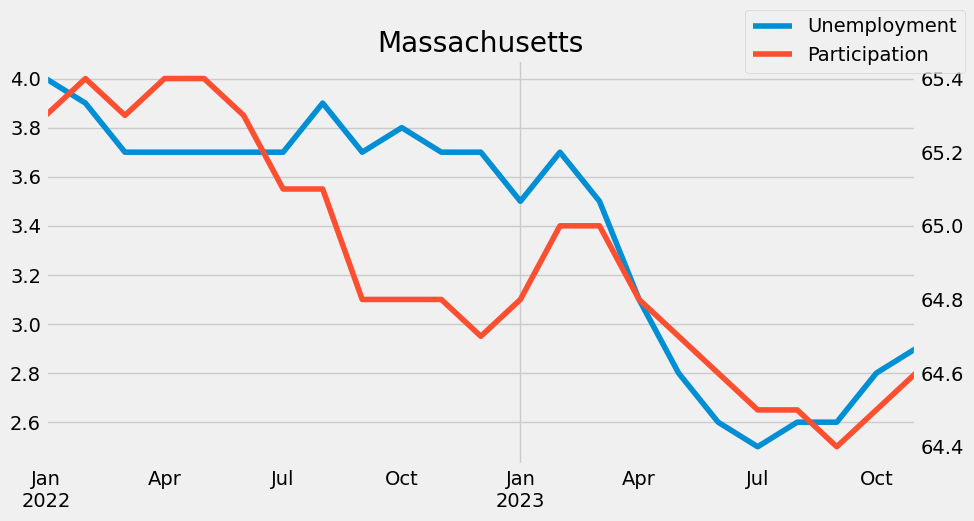

In [39]:
# Specify the target state
state = 'Massachusetts'

# Create a new subplot with a specified size
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)

# Create a twin Axes sharing the xaxis
ax2 = ax.twinx()

# Resample the DataFrame to monthly frequency
uemp_states2 = uemp_states.asfreq('MS')

# Plot the unemployment rate for the specified state
l1 = uemp_states2.query('index >= 2022 and index < 2024')[state] \
    .plot(ax=ax, label='Unemployment')

# Plot the participation rate for the specified state on the secondary y-axis
l2 = part_states.dropna().query('index >= 2022 and index < 2024')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])

# Turn off the grid on the secondary y-axis
ax2.grid(False)

# Set the title of the plot
ax.set_title(state)

# Add a legend with specified labels
fig.legend(labels=['Unemployment','Participation'])

# Display the plot
plt.show()